In [1]:
import os
import pydicom
import numpy as np
from pprint import pprint
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from skimage import exposure
from skimage.transform import resize 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


In [2]:
# pre-crop 

def precrop(np_data, threshold=100000):

    x_axis = np.sum(np_data, axis=0)
    y_axis = np.sum(np_data, axis=1)

    x_start, x_end, y_start, y_end = -1,-1,-1,-1

    for index, value in enumerate(x_axis):
        if value > threshold: 
            x_start = index
            break
    for index in range(len(x_axis)-1, -1, -1):
        if x_axis[index] > threshold:
            x_end = index
            break
    for index, value in enumerate(y_axis):
        if value > threshold: 
            y_start = index
            break
    for index in range(len(y_axis)-1, -1, -1):
        if y_axis[index] > threshold:
            y_end = index
            break

    np_cropped = np_data[y_start:y_end,x_start:x_end]
 
    return np_cropped 


In [3]:
raw_data = "data/raw_data"

infanto = {}

filelist = os.listdir(raw_data)
for file in filelist:
    infanto[file] = dict()
    ds = pydicom.dcmread(raw_data + "/" + file)
    
    infanto[file]['np'] = ds.pixel_array
    infanto[file]['np_precrop'] = precrop(infanto[file]['np'])
    infanto[file]['size'] = infanto[file]['np_precrop'].shape
    infanto[file]['pil'] = Image.fromarray(infanto[file]['np_precrop'])




In [4]:
# ratio에 따라 image crop

ratio = 1.0

for file in infanto:
    im = infanto[file]['pil']
    height, width = infanto[file]['size']
    
    if height > ratio * width:
        im_crop = im.crop((0, 0, width, int(ratio * width) ))
        infanto[file]['pil_cropped'] = im_crop
    else:
        im_crop = im.crop((0, 0, int(width/ratio), width ))
        infanto[file]['pil_cropped'] = im_crop

In [25]:
# normalize, resize



for file in infanto:
    #infanto[file]['data'] = np.asarray(infanto[file]['pil_cropped'])
    tmp = np.asarray(infanto[file]['pil_cropped'])
    max_ = np.max(tmp)
    min_ = np.min(tmp)
    tmp  = tmp - min_
    tmp  = tmp / (max_ - min_)
    
    infanto[file]['data'] = resize(tmp, (640, 640))

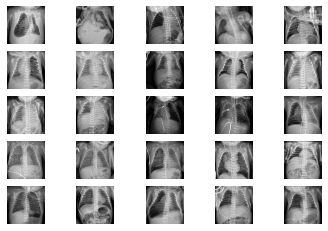

In [27]:
fgsh, axarr = plt.subplots(5,5)

for i in range(25):
    sub_plt = axarr[int(i/5), i%5]
    sub_plt.axis('off')
    sub_plt.imshow(infanto[str(10000 + i) + '.DCM']['data'], cmap='gray')
    
plt.show()

  
    
    

In [ ]:


def preprocess_adapthist(x):
    result = exposure.equalize_adapthist(x[:,:,0], clip_limit=0.03)
    result = np.expand_dims(result, axis=-1)
    if x.shape[2] == 3:
        result = np.concatenate((result,)*3, axis=-1)
    result = vnormalize(x=result, m=[np.min(result), np.max(result)])
    return result

def preprocess_normonly(x):
    return vnormalize(x=x, m=[np.min(x), np.max(x)])

data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=False,
                     fill_mode='nearest',
                     preprocessing_function=preprocess_adapthist)

image_datagen = ImageDataGenerator(**data_gen_args)



train_generator = my_data_gen(partition['train'], datasetpath, image_datagen, **my_data_gen_args)
valid_generator = my_data_gen(partition['valid'], datasetpath, image_datagen, **my_data_gen_args)